In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
df = pd.read_csv('/kaggle/input/fundus-dataset/dataset.csv')

In [4]:
df

,image_path,class,label_encoded
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
...,...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5


In [5]:
# Görüntüleri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).resize(target_size)  # Görüntüyü yeniden boyutlandır
    image = np.array(image) / 255.0  # Normalizasyon (0-1 aralığına getir)
    return image

In [53]:
# One-hot encoding işlemi
y = to_categorical(df['label_encoded'])

# Görüntüleri ve etiketleri yükleme
X = np.array([load_and_preprocess_image(path) for path in df['image_path']])

# Veriyi eğitim, doğrulama ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # %70 eğitim, %30 geçici
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # %15 doğrulama, %15 test

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)
print("Test verisi şekli:", X_test.shape)

Eğitim verisi şekli: (3158, 224, 224, 3)
Doğrulama verisi şekli: (677, 224, 224, 3)
Test verisi şekli: (677, 224, 224, 3)


In [54]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Veri arttırma için ImageDataGenerator oluştur
datagen = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)



# Veriyi fit etmek yerine eğitim sırasında generator ile kullanmak
train_generator = datagen.flow(X_train, y_train, batch_size=32)

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout, Flatten, Reshape, UpSampling2D  # Import UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, gating_channels, inter_channels, up_factor=2, normalize_attn=False):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', use_bias=False)
        self.W_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', use_bias=False)
        self.psi = Conv2D(1, kernel_size=1, strides=1, padding='same', use_bias=False)
        self.softmax = tf.keras.layers.Softmax(axis=-1)
        self.up = UpSampling2D(size=(up_factor, up_factor))

    def call(self, x, g):
        theta_x = self.W_x(x)
        phi_g = self.W_g(g)

        # Resize phi_g to match theta_x spatially before addition
        phi_g = tf.image.resize(phi_g, (theta_x.shape[1], theta_x.shape[2])) # Resize!

        f = tf.nn.relu(theta_x + phi_g)
        sigm_psi_f = tf.nn.sigmoid(self.psi(f))
        if self.up_factor > 1:
            sigm_psi_f = self.up(sigm_psi_f)
        return sigm_psi_f, g


class AttnVGG(tf.keras.Model):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()

        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        # Correct way to get layer outputs using layer names and handle input shapes
        self.conv_block1 = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv2').output)
        self.conv_block2 = Model(inputs=base_model.input, outputs=base_model.get_layer('block2_conv2').output)
        self.conv_block3 = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_conv3').output)
        self.conv_block4 = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)
        self.conv_block5 = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

        self.pool = GlobalAveragePooling2D()
        self.dropout = Dropout(dropout) if dropout else None
        self.cls = Dense(num_classes, activation='softmax')

        self.attn1 = AttentionBlock(256, 512, 256, up_factor=4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, up_factor=2, normalize_attn=normalize_attn)

    def call(self, x, training=False):
        block1 = self.conv_block1(x)
        pool1 = MaxPooling2D(pool_size=(2, 2))(block1)

        block2 = self.conv_block2(x)  # Input is ORIGINAL image x
        pool2 = MaxPooling2D(pool_size=(2, 2))(block2)

        block3 = self.conv_block3(x)  # Input is ORIGINAL image x
        pool3 = MaxPooling2D(pool_size=(2, 2))(block3)

        block4 = self.conv_block4(x)  # Input is ORIGINAL image x
        pool4 = MaxPooling2D(pool_size=(2, 2))(block4)

        block5 = self.conv_block5(x)  # Input is ORIGINAL image x
        pool5 = MaxPooling2D(pool_size=(2, 2))(block5)


        g = self.pool(pool5)  # (batch_size, 512)

        a1, g1 = self.attn1(pool3, pool5)  # (batch_size, 28, 28, 1), (batch_size, 7, 7, 512)
        a2, g2 = self.attn2(pool4, pool5)  # (batch_size, 14, 14, 1), (batch_size, 7, 7, 512)

        # Flatten the attention maps before concatenation
        g1 = Flatten()(g1)  # (batch_size, 28*28*1)
        g2 = Flatten()(g2)  # (batch_size, 14*14*1)


        g_hat = tf.concat([g, g1, g2], axis=-1)  # Concatenate along the last axis

        if self.dropout:
            g_hat = self.dropout(g_hat, training=training)

        out = self.cls(g_hat)

        return [out, a1, a2]


input_shape = (224, 224, 3)
num_classes = 8
model = AttnVGG(num_classes=num_classes, normalize_attn=True, dropout=0.5)

# 3. Compile the model (loss, optimizer, metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

dummy_input = tf.random.normal((32, 224, 224, 3))
output = model(dummy_input)

out, a1, a2 = output  # Assuming your model returns [output, attention_map1, attention_map2]

print(f"Çıkış Sınıfı: {output[0].shape}")
print(f"Attention 1 Haritası: {output[1].shape}")
print(f"Attention 2 Haritası: {output[2].shape}")

Çıkış Sınıfı: (32, 8)
Attention 1 Haritası: (32, 112, 112, 1)
Attention 2 Haritası: (32, 28, 28, 1)


In [57]:
import tensorflow as tf

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, from_logits=False, reduction='sum_over_batch_size', name='focal_loss'): # Corrected reduction
        super().__init__(reduction=reduction, name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        else:
            bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)

        pt = tf.exp(-bce)
        f_loss = self.alpha * (1 - pt)**self.gamma * bce
        return f_loss

# Example usage:
loss = FocalLoss(alpha=0.25, gamma=2.0)  # Default values or pass reduction = 'none' or 'sum'

# In your model compilation:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss, metrics=['accuracy'])


In [58]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (3158, 224, 224, 3)
y_train shape: (3158, 8)


In [61]:
import tensorflow as tf


class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='custom_accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.correct_predictions = self.add_weight(name='correct_predictions', initializer='zeros')
        self.total_predictions = self.add_weight(name='total_predictions', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Argmax to get predicted class
        y_pred_classes = tf.argmax(y_pred, axis=-1)
        y_true_classes = tf.argmax(y_true, axis=-1)
        
        # Calculate correct predictions
        correct = tf.equal(y_true_classes, y_pred_classes)
        
        # Count the correct predictions and total predictions
        self.correct_predictions.assign_add(tf.reduce_sum(tf.cast(correct, tf.float32)))
        self.total_predictions.assign_add(tf.cast(tf.size(y_true_classes), tf.float32))

    def result(self):
        return self.correct_predictions / self.total_predictions

    def reset_states(self):
        self.correct_predictions.assign(0)
        self.total_predictions.assign(0)

# Modeli derlerken Custom Metrik kullanımı
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss,
              metrics=[CustomAccuracy(), CustomAccuracy(), CustomAccuracy()])  # 3 çıkış için 3 tane custom accuracy





# Eğitim parametrelerini ayarlayın
epochs = 100  # Epoch sayısı
batch_size = 32  # Batch boyutu

# Modeli eğitin
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))  # Doğrulama verisi de ekleyebilirsiniz



Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - custom_accuracy: 0.6119 - loss: 0.0024 - val_custom_accuracy: 0.5451 - val_loss: 0.0028
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - custom_accuracy: 0.6347 - loss: 0.0021 - val_custom_accuracy: 0.5406 - val_loss: 0.0027
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - custom_accuracy: 0.6519 - loss: 0.0020 - val_custom_accuracy: 0.5362 - val_loss: 0.0029
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - custom_accuracy: 0.6540 - loss: 0.0019 - val_custom_accuracy: 0.5332 - val_loss: 0.0027
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - custom_accuracy: 0.6620 - loss: 0.0017 - val_custom_accuracy: 0.5480 - val_loss: 0.0028
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - custom_accuracy: 0.6677 - loss: 0.0017 - val_custom_accuracy: 0.5495 - val_loss: 0.0027
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - custom_accuracy: 0.6699 - loss: 0.0016 - val_custom_accuracy: 0.5318 - val_loss: 0.0027
Epoc

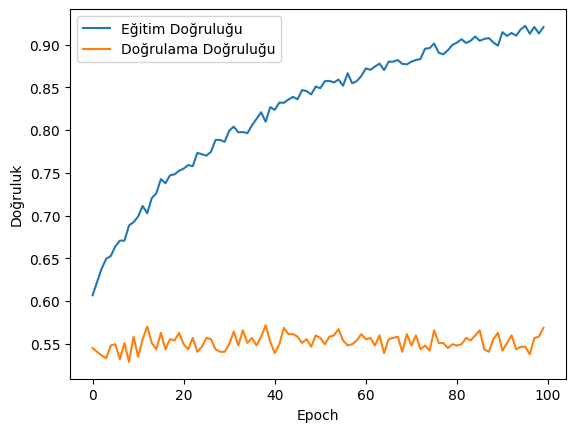

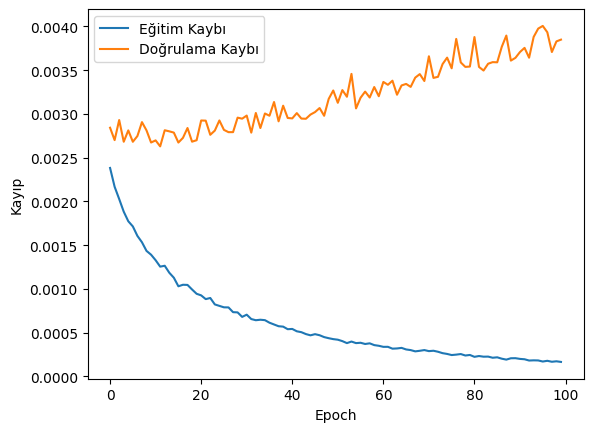

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - custom_accuracy: 0.5478 - loss: 0.0035
Test Kaybı: 0.003698710585013032
Test Doğruluğu: 0.5568685531616211


In [63]:
# Eğitim sonuçlarını görselleştirme (isteğe bağlı)
import matplotlib.pyplot as plt

plt.plot(history.history['custom_accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_custom_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Modeli kaydedin (isteğe bağlı)
model.save('model.h5')  # veya farklı bir format

# Modeli değerlendirin (isteğe bağlı)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Kaybı: {loss}")
print(f"Test Doğruluğu: {accuracy}")

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# VGG16 modelini temel olarak kullanıyoruz (ImageNet ağırlıklarıyla önceden eğitilmiş)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# VGG16'nın üst katmanlarını çıkarıyoruz
base_model.trainable = False  # Katmanları donduruyoruz, ağırlıklar değişmeyecek

# Son katmanları ekliyoruz
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)  # Dropout ekliyoruz
x = Dense(1024, activation='relu')(x)  # Fully connected katman
output = Dense(8, activation='softmax')(x)  # Çıkış katmanı (8 sınıf)

# Yeni modelin tanımlanması
model = Model(inputs=base_model.input, outputs=output)

# Modeli derliyoruz
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy verilerle eğitim örneği
# Burada X_train, y_train, X_val ve y_val'yi kendi verilerinizle değiştirin
epochs = 100
batch_size = 32

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.1534 - loss: 2.1088 - val_accuracy: 0.3072 - val_loss: 1.9848
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.2602 - loss: 1.9878 - val_accuracy: 0.3781 - val_loss: 1.8990
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3170 - loss: 1.8975 - val_accuracy: 0.3663 - val_loss: 1.8117
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3454 - loss: 1.8523 - val_accuracy: 0.3900 - val_loss: 1.7625
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3523 - loss: 1.8018 - val_accuracy: 0.3870 - val_loss: 1.7351
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3602 - loss: 1.7844 - val_accuracy: 0.3973 - val_loss: 1.6977
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3805 - loss: 1.7339 - val_accuracy: 0.4003 - val_loss: 1.6663
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.3832 - loss: 1.7177 - val_accuracy: 

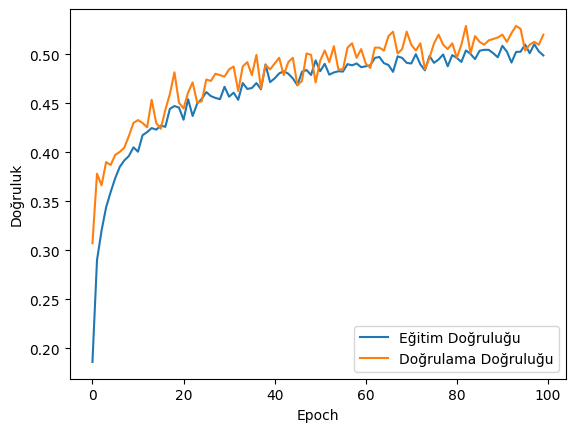

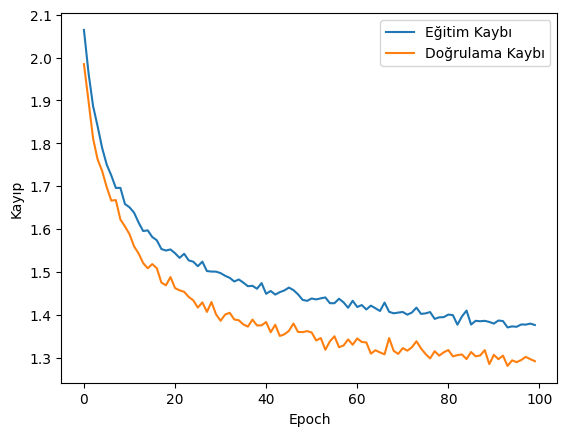

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5401 - loss: 1.2647
Test Kaybı: 1.262452244758606
Test Doğruluğu: 0.5450516939163208


In [65]:
# Eğitim sonuçlarını görselleştirme (isteğe bağlı)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Modeli kaydedin (isteğe bağlı)
model.save('model.h5')  # veya farklı bir format

# Modeli değerlendirin (isteğe bağlı)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Kaybı: {loss}")
print(f"Test Doğruluğu: {accuracy}")